In [5]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn import tree, model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [91]:
df1 = pd.read_csv('LR_1df.csv')
df1

,subject_id,admission_type,discharge_location,marital_status,race,BINARY_DEATH,gender,anchor_age,count_icu,count_adm,icd_code,long_title
0,10000032,URGENT,HOME,WIDOWED,WHITE,0,F,52,1.0,4,5723,Portal hypertension
1,10000068,EU OBSERVATION,NaN,SINGLE,WHITE,0,F,19,0.0,1,30500,"Alcohol abuse, unspecified"
2,10000084,EW EMER.,HOME HEALTH CARE,MARRIED,WHITE,0,M,72,0.0,2,G3183,Dementia with Lewy bodies
3,10000108,EU OBSERVATION,NaN,SINGLE,WHITE,0,M,25,0.0,1,5283,Cellulitis and abscess of oral soft tissues
4,10000117,EU OBSERVATION,NaN,DIVORCED,WHITE,0,F,48,0.0,2,R1310,"Dysphagia, unspecified"
...,...,...,...,...,...,...,...,...,...,...,...,...
179924,19999733,EU OBSERVATION,NaN,SINGLE,WHITE,0,F,19,0.0,1,9953,"Allergy, unspecified, not elsewhere classified"
179925,19999784,ELECTIVE,HOME HEALTH CARE,SINGLE,BLACK/AFRICAN AMERICAN,0,M,57,0.0,18,Z5111,Encounter for antineoplastic chemotherapy
179926,19999828,EW EMER.,HOME HEALTH CARE,SINGLE,WHITE,0,F,46,1.0,2,T8141XA,"Infection following a procedure, superficial i..."
179927,19999840,EW EMER.,DIED,WIDOWED,WHITE,1,M,58,1.0,2,3453,Grand mal status


In [93]:
#Como os modelos logisticregressation não lêm string, o genero vou passar para sistema binario em que 1-M e 0-F
df1['gender'] = df1['gender'].replace('M', int(1))
df1['gender'] = df1['gender'].replace('F', int(0))

In [282]:
# vou cortar o dataset para pequena amostra de DP     ---> ter a noção se não ter cuidados em casa leva a pessoa regressar ao hospital.
X_sample = df1.sample(n=1000, random_state=42) 
X = X_sample[['anchor_age', 'gender', 'discharge_location']]
y_sample = df1.sample(n=1000, random_state=42) 
y = y_sample['count_adm']

In [298]:
y = y.to_frame()

In [300]:
# target será 0 - não voltou ao hospital; 1 - voltou ao hospital.
y.loc[y['count_adm'] == 1, 'count_adm' ] = 0
y.loc[y['count_adm'] > 1, 'count_adm'] = 1

In [278]:
y

,index,count_adm
0,147454,0
1,72655,0
2,55649,0
3,84036,0
4,34190,0
...,...,...
995,144693,0
996,174176,0
997,49859,0
998,93908,0


In [302]:
X

,anchor_age,gender,discharge_location
147454,64,1,NaN
72655,54,0,NaN
55649,69,0,HOME
84036,59,0,HOME
34190,36,0,NaN
...,...,...,...
144693,78,0,SKILLED NURSING FACILITY
174176,33,0,HOME
49859,46,0,HOME HEALTH CARE
93908,91,1,CHRONIC/LONG TERM ACUTE CARE


In [304]:
X['discharge_location'].value_counts()

HOME                            396
HOME HEALTH CARE                142
SKILLED NURSING FACILITY         93
REHAB                            33
DIED                             32
CHRONIC/LONG TERM ACUTE CARE     11
AGAINST ADVICE                    8
ACUTE HOSPITAL                    8
PSYCH FACILITY                    7
OTHER FACILITY                    4
ASSISTED LIVING                   2
HOSPICE                           2
Name: discharge_location, dtype: int64

In [306]:
#Como os modelos logisticregressation não lêm string,vou passar NaN - 0; HOME - 1; HOME HEALTH CARE -2; ....
X['discharge_location'] = X['discharge_location'].replace(np.nan, int(0))
X['discharge_location'] = X['discharge_location'].replace('HOME', int(1))
X['discharge_location'] = X['discharge_location'].replace('HOME HEALTH CARE', int(2))
X['discharge_location'] = X['discharge_location'].replace('SKILLED NURSING FACILITY', int(3))
X['discharge_location'] = X['discharge_location'].replace('REHAB', int(4))
X['discharge_location'] = X['discharge_location'].replace('DIED', int(5))
X['discharge_location'] = X['discharge_location'].replace('CHRONIC/LONG TERM ACUTE CARE', int(6))
X['discharge_location'] = X['discharge_location'].replace('AGAINST ADVICE', int(7))
X['discharge_location'] = X['discharge_location'].replace('ACUTE HOSPITAL', int(8))
X['discharge_location'] = X['discharge_location'].replace('PSYCH FACILITY', int(9))
X['discharge_location'] = X['discharge_location'].replace('OTHER FACILITY', int(10))
X['discharge_location'] = X['discharge_location'].replace('ASSISTED LIVING', int(11))
X['discharge_location'] = X['discharge_location'].replace('HOSPICE', int(12))

/tmp/ipykernel_100/1812554407.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['discharge_location'] = X['discharge_location'].replace(np.nan, int(0))
/tmp/ipykernel_100/1812554407.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['discharge_location'] = X['discharge_location'].replace('HOME', int(1))
/tmp/ipykernel_100/1812554407.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [308]:
X['discharge_location'].isna().value_counts()

False    1000
Name: discharge_location, dtype: int64

In [310]:
y

,count_adm
147454,0
72655,1
55649,1
84036,1
34190,0
...,...
144693,0
174176,1
49859,1
93908,0


In [312]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [314]:
y_test.value_counts()

count_adm
0            201
1            129
dtype: int64

Logistic Regressation

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.0, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.02040816326530612, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.04081632653061224, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.061224489795918366, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.08163265306122448, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.1020408163265306, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.12244897959183673, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.14285714285714285, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.16326530612244897, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.18367346938775508, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.2040816326530612, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.22448979591836732, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.24489795918367346, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.26530612244897955, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.2857142857142857, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.3061224489795918, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.32653061224489793, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.3469387755102041, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.36734693877551017, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.3877551020408163, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.4081632653061224, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.42857142857142855, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.44897959183673464, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.4693877551020408, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.4897959183673469, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.5102040816326531, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.5306122448979591, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.5510204081632653, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.5714285714285714, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.5918367346938775, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.6122448979591836, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.6326530612244897, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.6530612244897959, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.673469387755102, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.6938775510204082, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.7142857142857142, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.7346938775510203, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.7551020408163265, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.7755102040816326, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.7959183673469387, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.8163265306122448, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.836734693877551, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.8571428571428571, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.8775510204081632, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.8979591836734693, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.9183673469387754, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.9387755102040816, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.9591836734693877, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.9795918367346939, 1: 1})

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 1.0, 1: 1})

[0.0,
 0.02040816326530612,
 0.04081632653061224,
 0.061224489795918366,
 0.08163265306122448,
 0.1020408163265306,
 0.12244897959183673,
 0.14285714285714285,
 0.16326530612244897,
 0.18367346938775508,
 0.2040816326530612,
 0.22448979591836732,
 0.24489795918367346,
 0.26530612244897955,
 0.2857142857142857,
 0.3061224489795918,
 0.32653061224489793,
 0.3469387755102041,
 0.36734693877551017,
 0.3877551020408163,
 0.4081632653061224,
 0.42857142857142855,
 0.44897959183673464,
 0.4693877551020408,
 0.4897959183673469,
 0.5102040816326531,
 0.5306122448979591,
 0.5510204081632653,
 0.5714285714285714,
 0.5918367346938775,
 0.6122448979591836,
 0.6326530612244897,
 0.6530612244897959,
 0.673469387755102,
 0.6938775510204082,
 0.7142857142857142,
 0.7346938775510203,
 0.7551020408163265,
 0.7755102040816326,
 0.7959183673469387,
 0.8163265306122448,
 0.836734693877551,
 0.8571428571428571,
 0.8775510204081632,
 0.8979591836734693,
 0.9183673469387754,
 0.9387755102040816,
 0.95918367346

37

0.7551020408163265

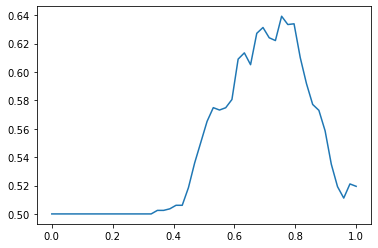

In [323]:
array = []
n = np.linspace(0, 1)
n = list(n)
for i in n:
    model = LogisticRegression(class_weight = {0:i,1:1})
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    auc = roc_auc_score(y_test, pred)
    array.append(auc)

graph = plt.plot(n, array)
n
ind_max = np.argmax(array)
ind_max
max_weight = n[ind_max]
max_weight
plt.show()


In [325]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(X_train)
X_train_encoded = encoder.transform(X_train)
encoder.categories_
encoder.get_feature_names_out()

OneHotEncoder(handle_unknown='ignore')

[array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
        69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
        86, 87, 88, 89, 91]),
 array([0, 1]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])]

array(['anchor_age_18', 'anchor_age_19', 'anchor_age_20', 'anchor_age_21',
       'anchor_age_22', 'anchor_age_23', 'anchor_age_24', 'anchor_age_25',
       'anchor_age_26', 'anchor_age_27', 'anchor_age_28', 'anchor_age_29',
       'anchor_age_30', 'anchor_age_31', 'anchor_age_32', 'anchor_age_33',
       'anchor_age_34', 'anchor_age_35', 'anchor_age_36', 'anchor_age_37',
       'anchor_age_38', 'anchor_age_39', 'anchor_age_40', 'anchor_age_41',
       'anchor_age_42', 'anchor_age_43', 'anchor_age_44', 'anchor_age_45',
       'anchor_age_46', 'anchor_age_47', 'anchor_age_48', 'anchor_age_49',
       'anchor_age_50', 'anchor_age_51', 'anchor_age_52', 'anchor_age_53',
       'anchor_age_54', 'anchor_age_55', 'anchor_age_56', 'anchor_age_57',
       'anchor_age_58', 'anchor_age_59', 'anchor_age_60', 'anchor_age_61',
       'anchor_age_62', 'anchor_age_63', 'anchor_age_64', 'anchor_age_65',
       'anchor_age_66', 'anchor_age_67', 'anchor_age_68', 'anchor_age_69',
       'anchor_age_70', '

In [327]:
X_test

,anchor_age,gender,discharge_location
117824,65,1,0
108126,81,1,2
28267,64,0,0
172342,45,0,2
146005,39,0,1
...,...,...,...
20987,52,1,0
13505,45,0,1
175588,65,0,6
58777,43,1,0


In [329]:
X_test_encoded = encoder.transform(X_test)
X_test_encoded

<330x88 sparse matrix of type '<class 'numpy.float64'>'
	with 990 stored elements in Compressed Sparse Row format>

In [331]:
clf = LogisticRegression(class_weight = {0:0.0408,1:1})
clf.fit(X_train_encoded,y_train)
pred = clf.predict(X_test_encoded)  

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.0408, 1: 1})

In [333]:
clf.get_params()

{'C': 1.0,
 'class_weight': {0: 0.0408, 1: 1},
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

,0,1
0,0,201
1,0,129


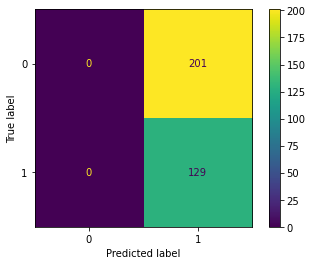

Accuracy: 0.39090909090909093
Precision: 0.39090909090909093
Recall: 1.0
ROC: 0.5

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       201
           1       0.39      1.00      0.56       129

    accuracy                           0.39       330
   macro avg       0.20      0.50      0.28       330
weighted avg       0.15      0.39      0.22       330



/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [335]:
cm = confusion_matrix(y_test, pred, labels=clf.classes_)
pd.DataFrame(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

print(f'Accuracy: {accuracy_score(y_test, pred)}')
print(f'Precision: {precision_score(y_test, pred)}')
print(f'Recall: {recall_score(y_test, pred)}')
print(f'ROC: {roc_auc_score(y_test, pred)}')

print()
print(classification_report(y_test, pred))

DecisionTree

In [337]:
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,None]
class_weight = [{0:0.0005,1:1}, {0:0.001,1:1}, {0:0.0015,1:1}]
param_grid = {'criterion': criterion, 'max_depth': max_depth, 'class_weight': class_weight}

In [339]:
tune_model = GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = 3)
tune_model.fit(X_train_encoded, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [{0: 0.0005, 1: 1}, {0: 0.001, 1: 1},
                                          {0: 0.0015, 1: 1}],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, None]},
             scoring='roc_auc')

In [341]:
tune_model.best_params_
tune_model.get_params()

{'class_weight': {0: 0.0015, 1: 1}, 'criterion': 'entropy', 'max_depth': None}

{'cv': 3,
 'error_score': nan,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__random_state': None,
 'estimator__splitter': 'best',
 'estimator': DecisionTreeClassifier(),
 'n_jobs': None,
 'param_grid': {'criterion': ['gini', 'entropy'],
  'max_depth': [2, 4, 6, 8, 10, None],
  'class_weight': [{0: 0.0005, 1: 1}, {0: 0.001, 1: 1}, {0: 0.0015, 1: 1}]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': 'roc_auc',
 'verbose': 0}

In [343]:
clf_tree = DecisionTreeClassifier(criterion='gini', max_depth=None, class_weight= {0: 0.001, 1: 1})
clf_tree = clf_tree.fit(X_train_encoded, y_train)
clf_tree.get_params()
clf_tree.get_n_leaves()

{'ccp_alpha': 0.0,
 'class_weight': {0: 0.001, 1: 1},
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

276

In [345]:
pred_tree = clf_tree.predict(X_test_encoded)
pred_tree

array([0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,

,0,1
0,83,118
1,47,82


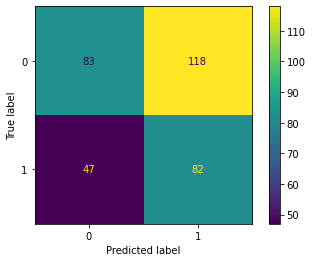

Accuracy: 0.5
Precision: 0.41
Recall: 0.6356589147286822
ROC: 0.5242971190558834

              precision    recall  f1-score   support

           0       0.64      0.41      0.50       201
           1       0.41      0.64      0.50       129

    accuracy                           0.50       330
   macro avg       0.52      0.52      0.50       330
weighted avg       0.55      0.50      0.50       330



In [347]:

cm = confusion_matrix(y_test, pred_tree, labels=clf.classes_)
pd.DataFrame(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

print(f'Accuracy: {accuracy_score(y_test, pred_tree)}')
print(f'Precision: {precision_score(y_test, pred_tree)}')
print(f'Recall: {recall_score(y_test, pred_tree)}')
print(f'ROC: {roc_auc_score(y_test, pred_tree)}')

print()
print(classification_report(y_test, pred_tree))